<a href="https://colab.research.google.com/github/maksmanikowski/neural_networks/blob/main/dl06_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning
<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/marcinsawinski/UEP_KIE_DL_CODE/blob/main/dl06_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

__Try transfer learning to reuse pre-trained models to improve accuracy / reduce time of traning__

Get dataset from kaggle: multiclass-weather-dataset

Check the models you can leverage


https://www.tensorflow.org/api_docs/python/tf/keras/applications

https://keras.io/examples/vision/image_classification_from_scratch/#run-inference-on-new-data

https://keras.io/api/applications/#usage-examples-for-image-classification-models

https://www.tensorflow.org/tutorials/images/transfer_learning?hl=en#data_download

https://keras.io/guides/transfer_learning/

https://arxiv.org/abs/1905.11946

You can review a tutorial notebook
https://www.kaggle.com/code/ahmedtronic/weather-conditions-classification-acc-97/notebook


In [ ]:
import pandas as pd
import os
from random import seed
from random import random
from shutil import copyfile
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls 'drive/MyDrive/Colab Notebooks/Multi-class Weather Dataset'

Cloudy	Rain  Shine  Sunrise


https://stackoverflow.com/questions/53074712/how-to-split-folder-of-images-into-test-training-validation-sets-with-stratified

In [ ]:
num_skipped = 0
for folder_name in ("Cloudy", "Rain", "Shine", "Sunrise"):
    folder_path = os.path.join("drive/MyDrive/Colab Notebooks/Multi-class Weather Dataset", folder_name)
    print(folder_path)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

drive/MyDrive/Colab Notebooks/Multi-class Weather Dataset/Cloudy
drive/MyDrive/Colab Notebooks/Multi-class Weather Dataset/Rain
drive/MyDrive/Colab Notebooks/Multi-class Weather Dataset/Shine
drive/MyDrive/Colab Notebooks/Multi-class Weather Dataset/Sunrise
Deleted 0 images


In [ ]:
image_size = (224, 224)
batch_size = 32

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "drive/MyDrive/Colab Notebooks/Multi-class Weather Dataset",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 1085 files belonging to 4 classes.
Using 868 files for training.
Using 217 files for validation.


In [ ]:
val_batches = tf.data.experimental.cardinality(val_ds)

test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

In [ ]:
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_ds))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of train batches: 28
Number of validation batches: 4
Number of test batches: 3


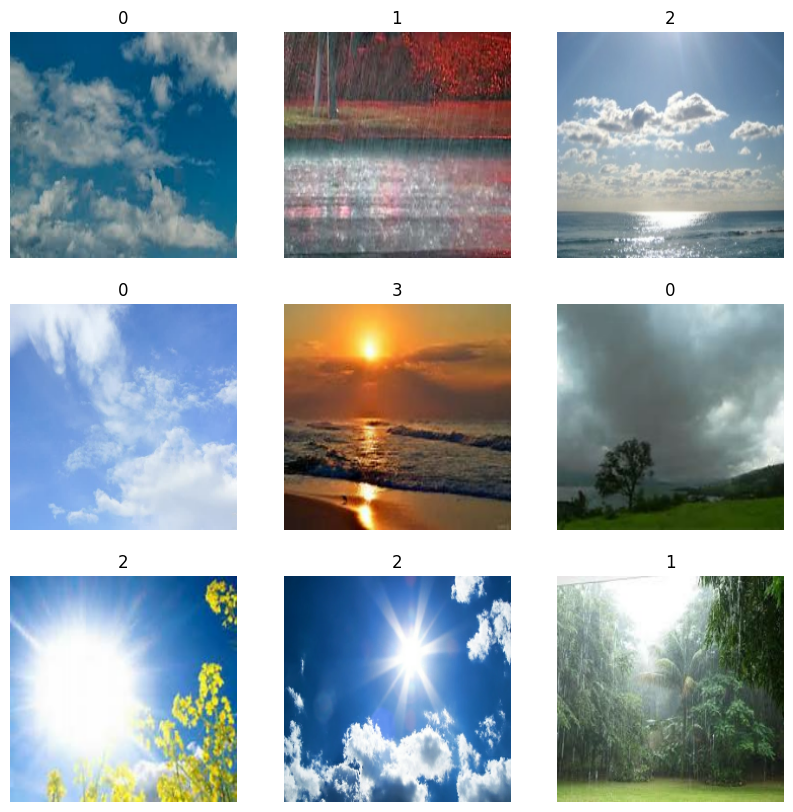

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
    ]
)

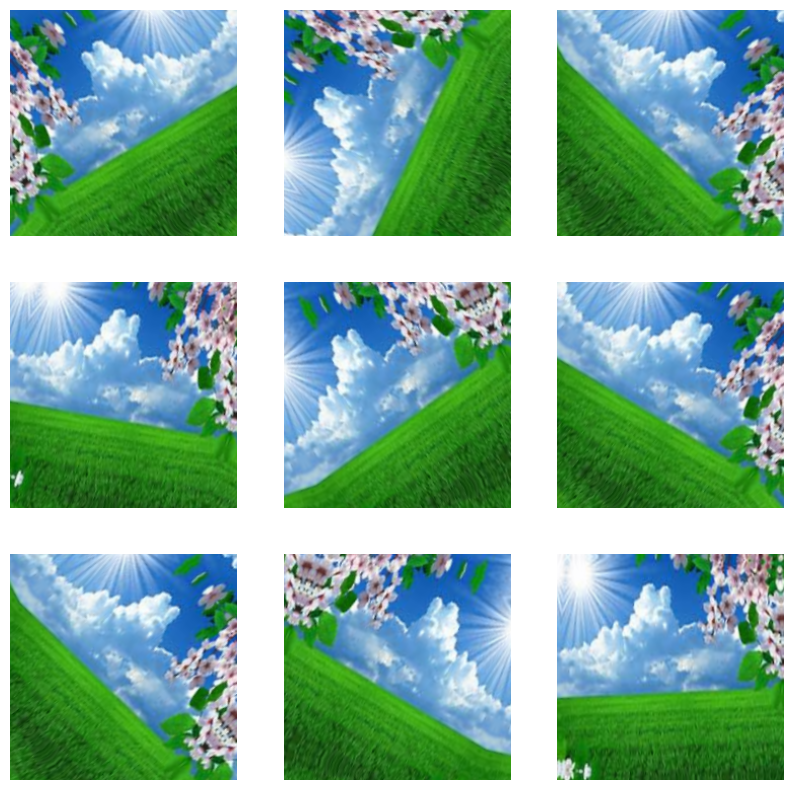

In [ ]:
for image, _ in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [ ]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape) # 32 images 224x224 with 3 channels
    print(labels_batch.shape) # 32 corresponding labels
    break

(32, 224, 224, 3)
(32,)


In [ ]:
some_batch = train_ds.take(1)
for image, label in some_batch:
    print(label[0])
    print(image[0])
    break

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights= True)

In [ ]:
model_conv = tf.keras.Sequential(
    [
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    #tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    #tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(300, activation="relu", name="hidden1"),
    tf.keras.layers.Dense(128, activation="relu", name="hidden2"),
    tf.keras.layers.Dense(4, activation="softmax", name="output"),
    ]
    )

model_conv.summary()

model_conv.compile(loss="sparse_categorical_crossentropy",
              optimizer='adam',
              metrics=["accuracy"])

history = model_conv.fit(train_ds, epochs=10,
                         validation_data=val_ds,
                         callbacks = [early_stopping])

https://keras.io/api/preprocessing/image/#imagedatagenerator-class

https://stackoverflow.com/questions/70477631/batchdataset-get-img-array-and-labels

In [ ]:
# Apply `data_augmentation` to the training images.
# train_ds = train_ds.map(
#     lambda img, label: (data_augmentation(img), label),
#     num_parallel_calls=tf.data.AUTOTUNE,
# )
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [ ]:
preprocessed_train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y)) # preprocessing for resnet

In [ ]:
preprocessed_val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y))

In [ ]:
some_batch = preprocessed_train_ds.take(1)
for image, label in some_batch:
    some_image = image[0]
    print(label[0])
    print(some_image)
    break

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(
[[[ 45.123497    26.2835      14.3825    ]
  [ 49.482872    30.642876    18.741875  ]
  [ 58.842247    40.00225     28.10125   ]
  ...
  [ 16.904747    -6.9352493  -21.83625   ]
  [ 22.779747    -1.0602493  -15.96125   ]
  [ 24.045372     0.20537567 -14.695625  ]]

 [[ 48.833946    29.99395     18.092949  ]
  [ 52.595665    33.75567     21.854668  ]
  [ 60.35299     41.512993    29.611992  ]
  ...
  [ 16.863243    -6.976753   -21.877754  ]
  [ 23.286095    -0.5539017  -15.454903  ]
  [ 25.62252      1.7825241  -13.118477  ]]

 [[ 54.069786    35.22979     23.328789  ]
  [ 56.842735    38.00274     26.101738  ]
  [ 62.509727    43.66973     31.76873   ]
  ...
  [ 16.843712    -6.9962845  -21.897285  ]
  [ 23.732872    -0.10712433 -15.008125  ]
  [ 27.014122     3.1741257  -11.726875  ]]

 ...

 [[ 98.507286    84.66729     67.76629   ]
  [ 99.06686     85.22686     68.32586   ]
  [ 99.33492     85.49493     68.593925  ]
  ...
  [ 12.953087 

In [ ]:
base_model = tf.keras.applications.ResNet50(weights="imagenet", input_shape= (224, 224, 3), include_top=False)

In [ ]:
image_batch, label_batch = next(iter(preprocessed_train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 2048)


In [ ]:
base_model.summary()

In [ ]:
base_model.trainable = False

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights= True)

In [ ]:
log_dir="logs"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True)

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))

#x = data_augmentation(inputs)

x = preprocess_input(inputs)

# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.

x = base_model(x, training=False)

# Convert features of shape `base_model.output_shape[1:]` to vectors

x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dropout(0.2)(x)

#x = tf.keras.layers.Dense(128, activation="relu",
#                          kernel_initializer="he_normal")(x)

outputs = tf.keras.layers.Dense(4, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
lr = 0.001
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              metrics=["accuracy"])

history = model.fit(train_ds, epochs=20, validation_data=val_ds, callbacks=[early_stopping, tensorboard_callback])

Epoch 1/20
28/28 [==============================] - 147s 5s/step - loss: 0.9371 - accuracy: 0.6532 - val_loss: 0.2843 - val_accuracy: 0.9256
Epoch 2/20
 1/28 [>.............................] - ETA: 2:06 - loss: 0.2575 - accuracy: 0.8438

KeyboardInterrupt: ignored

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))

In [ ]:
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [ ]:
len(history.epoch)

In [ ]:
initial_epochs = len(history.epoch)

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              metrics=["accuracy"])

In [ ]:
fine_tune_epochs = 10

total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds,
                         callbacks=[early_stopping, tensorboard_callback])

Epoch 16/26
28/28 [==============================] - 13s 407ms/step - loss: 0.0107 - accuracy: 0.9988 - val_loss: 0.0687 - val_accuracy: 0.9669
Epoch 17/26
28/28 [==============================] - 12s 401ms/step - loss: 0.0100 - accuracy: 0.9988 - val_loss: 0.0685 - val_accuracy: 0.9752
Epoch 18/26
28/28 [==============================] - 12s 403ms/step - loss: 0.0107 - accuracy: 1.0000 - val_loss: 0.0689 - val_accuracy: 0.9669
Epoch 19/26
28/28 [==============================] - 12s 385ms/step - loss: 0.0098 - accuracy: 0.9988 - val_loss: 0.0684 - val_accuracy: 0.9752
Epoch 20/26
28/28 [==============================] - 13s 426ms/step - loss: 0.0106 - accuracy: 0.9965 - val_loss: 0.0688 - val_accuracy: 0.9669
Epoch 21/26
28/28 [==============================] - 14s 478ms/step - loss: 0.0082 - accuracy: 0.9988 - val_loss: 0.0698 - val_accuracy: 0.9752
Epoch 22/26
28/28 [==============================] - 12s 426ms/step - loss: 0.0089 - accuracy: 0.9977 - val_loss: 0.0697 - val_accuracy:

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

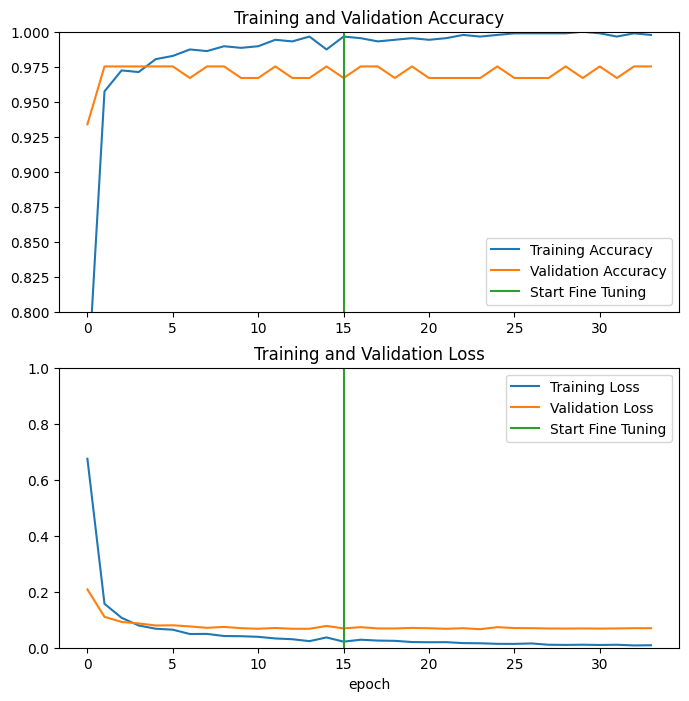

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([len(history.epoch)-1,len(history.epoch)-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([len(history.epoch)-1,len(history.epoch)-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

STARE

In [ ]:
model = tf.keras.Sequential(
    [
    base_model,
    #tf.keras.layers.BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    tf.keras.layers.Dense(128, activation="relu",
                          kernel_initializer="he_normal"),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation="softmax")
    ], name='cnn'
    )

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])
model.fit(preprocessed_train_ds, epochs=20, validation_data=preprocessed_val_ds) #callbacks=...,

Epoch 1/20
28/28 [==============================] - 15s 293ms/step - loss: 1.3437 - accuracy: 0.5253 - val_loss: 1.2910 - val_accuracy: 0.5945
Epoch 2/20
28/28 [==============================] - 8s 261ms/step - loss: 1.2369 - accuracy: 0.6486 - val_loss: 1.1751 - val_accuracy: 0.6728
Epoch 3/20
28/28 [==============================] - 7s 216ms/step - loss: 1.1054 - accuracy: 0.7097 - val_loss: 1.0435 - val_accuracy: 0.7097
Epoch 4/20
28/28 [==============================] - 9s 255ms/step - loss: 0.9645 - accuracy: 0.7350 - val_loss: 0.9174 - val_accuracy: 0.7465
Epoch 5/20
28/28 [==============================] - 8s 263ms/step - loss: 0.8371 - accuracy: 0.7765 - val_loss: 0.8181 - val_accuracy: 0.7742
Epoch 6/20
28/28 [==============================] - 7s 206ms/step - loss: 0.7377 - accuracy: 0.7926 - val_loss: 0.7436 - val_accuracy: 0.7696
Epoch 7/20
28/28 [==============================] - 8s 260ms/step - loss: 0.6618 - accuracy: 0.8041 - val_loss: 0.6918 - val_accuracy: 0.7834
Epoch

In [ ]:
img = tf.keras.preprocessing.image.load_img(
    "zachod.jpg", target_size=image_size
)

In [ ]:
img

In [ ]:
img = tf.keras.preprocessing.image.img_to_array(img)
img

In [ ]:
some_image = preprocess_input(img)
some_image = np.expand_dims(some_image, axis=0)

In [ ]:
preds = model.predict(some_image)
for j, pred in enumerate(preds[0]):
    print(f'Chances for {j} = {pred}')
# plt.imshow(images[i].numpy().astype("uint8"))
# plt.title(int(labels[i]))
# plt.axis("off")

1/1 [==============================] - 0s 25ms/step
Chances for 0 = 1.0288538760505617e-05
Chances for 1 = 3.5463500580590335e-07
Chances for 2 = 9.588887905920274e-07
Chances for 3 = 0.9999884366989136


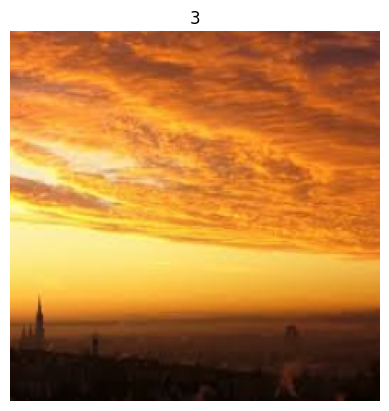

In [ ]:
for images, labels in train_ds.take(1):
    for i in range(1):
        some_image = preprocess_input(images[0])
        some_image = np.expand_dims(some_image, axis=0)
        preds = model.predict(some_image)
        for j, pred in enumerate(preds[0]):
            print(f'Chances for {j} = {pred}')
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
# some_image = np.expand_dims(some_image, axis=0)

In [ ]:
# some_image.shape

In [ ]:
# preds = model.predict(some_image)
# print('Predicted:', preds)

In [ ]:
# preds[0][0]

In [ ]:
# preds = base_model.predict(some_image)
# print('Predicted:', decode_predictions(preds, top=3)[0])